Source: https://keras.io/examples/nlp/pretrained_word_embeddings/
    

# Introduction
In this example, we show how to train a text classification model that uses pre-trained word embeddings.

We'll work with the Newsgroup20 dataset, a set of 20,000 message board messages belonging to 20 different topic categories.

For the pre-trained word embeddings, we'll use GloVe embeddings.

In [17]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pathlib

from datetime import datetime
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [12]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)
a = embedding_layer(tf.constant(np.arange(0, 1000))).numpy()
a.shape

(1000, 5)

# News Group dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.
    
The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

http://qwone.com/~jason/20Newsgroups/

In [20]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)
data_dir

PosixPath('/Users/abasar/.keras/datasets/20_newsgroup')

In [21]:
!ls -l /Users/abasar/.keras/datasets/20_newsgroup

total 0
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 alt.atheism
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 comp.graphics
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 comp.os.ms-windows.misc
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 comp.sys.ibm.pc.hardware
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 comp.sys.mac.hardware
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 comp.windows.x
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 misc.forsale
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 rec.autos
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 rec.motorcycles
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 rec.sport.baseball
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 rec.sport.hockey
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 sci.crypt
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 sci.electronics
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 sci.med
drwxr-xr-x  1002 abasar  staff  32064 Apr 20  1998 sci.sp

In [19]:
data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of directories: 20
Directory names: ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
Number of files in comp.graphics: 1000
Some example filenames: ['38254', '38402', '38630', '38865', '38891']


In [23]:
print(open(data_dir / "comp.graphics" / "38987").read())

Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!usc!rpi!nason110.its.rpi.edu!mabusj
From: mabusj@nason110.its.rpi.edu (Jasen M. Mabus)
Subject: Looking for Brain in CAD
Message-ID: <c285m+p@rpi.edu>
Nntp-Posting-Host: nason110.its.rpi.edu
Reply-To: mabusj@rpi.edu
Organization: Rensselaer Polytechnic Institute, Troy, NY.
Date: Thu, 29 Apr 1993 23:27:20 GMT
Lines: 7

Jasen Mabus
RPI student

	I am looking for a hman brain in any CAD (.dxf,.cad,.iges,.cgm,etc.) or picture (.gif,.jpg,.ras,etc.) format for an animation demonstration. If any has or knows of a location please reply by e-mail to mabusj@rpi.edu.

Thank you in advance,
Jasen Mabus  



As you can see, there are header lines that are leaking the file's category, either explicitly (the first line is literally the category name), or implicitly, e.g. via the Organization filed. Let's get rid of the headers:

In [24]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.ha

There's actually one category that doesn't have the expected number of files, but the difference is small enough that the problem remains a balanced classification problem.

In [25]:
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
/Users/abasar/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


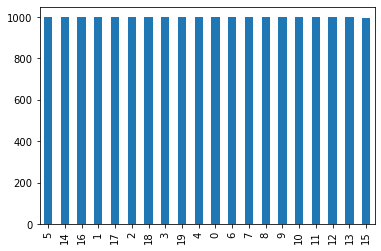

In [27]:
pd.Series(labels).value_counts().plot.bar()

In [28]:
# Shuffle and split the data into training and test sets
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

# Create a vocabulary index

Let's use the TextVectorization to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top 20,000 words, and will truncate or pad sequences to be actually 200 tokens long.

In [30]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

You can retrieve the computed vocabulary used via vectorizer.get_vocabulary(). Let's print the top 5 words:

In [33]:
print(vectorizer.get_vocabulary()[:50])

['', '[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'is', 'i', 'that', 'it', 'for', 'you', 'this', 'on', 'be', 'not', 'have', 'are', 'with', 'as', 'or', 'if', 'was', 'but', 'they', 'from', 'by', 'at', 'an', 'my', 'can', 'what', 'would', 'all', 'there', 'one', 'will', 'do', 'writes', 'about', 'we', 'he', 'has', 'so', 'your', 'article', 'no', 'any']


Let's vectorize a test sentence:


```

This layer has basic options for managing text in a Keras model. It
transforms a batch of strings (one sample = one string) into either a list of
token indices (one sample = 1D tensor of integer token indices) or a dense
representation (one sample = 1D tensor of float values representing data about
the sample's tokens).

If desired, the user can call this layer's adapt() method on a dataset.
When this layer is adapted, it will analyze the dataset, determine the
frequency of individual string values, and create a 'vocabulary' from them.
This vocabulary can have unlimited size or be capped, depending on the
configuration options for this layer; if there are more unique values in the
input than the maximum vocabulary size, the most frequent terms will be used
to create the vocabulary.

The processing of each sample contains the following steps:

  1. standardize each sample (usually lowercasing + punctuation stripping)
  2. split each sample into substrings (usually words)
  3. recombine substrings into tokens (usually ngrams)
  4. index tokens (associate a unique int value with each token)
  5. transform each sample using this index, either into a vector of ints or
     a dense float vector.


Attributes:
  max_tokens: The maximum size of the vocabulary for this layer. If None,
    there is no cap on the size of the vocabulary. Note that this vocabulary
    contains 1 OOV token, so the effective number of tokens is `(max_tokens -
    1 - (1 if output == "int" else 0))`.
  standardize: Optional specification for standardization to apply to the
    input text. Values can be None (no standardization),
    'lower_and_strip_punctuation' (lowercase and remove punctuation) or a
    Callable. Default is 'lower_and_strip_punctuation'.
  split: Optional specification for splitting the input text. Values can be
    None (no splitting), 'whitespace' (split on ASCII whitespace), or a
    Callable. The default is 'whitespace'.
  ngrams: Optional specification for ngrams to create from the possibly-split
    input text. Values can be None, an integer or tuple of integers; passing
    an integer will create ngrams up to that integer, and passing a tuple of
    integers will create ngrams for the specified values in the tuple. Passing
    None means that no ngrams will be created.
  output_mode: Optional specification for the output of the layer. Values can
    be "int", "binary", "count" or "tf-idf", configuring the layer as follows:
      "int": Outputs integer indices, one integer index per split string
        token. When output == "int", 0 is reserved for masked locations;
        this reduces the vocab size to max_tokens-2 instead of max_tokens-1
      "binary": Outputs a single int array per batch, of either vocab_size or
        max_tokens size, containing 1s in all elements where the token mapped
        to that index exists at least once in the batch item.
      "count": As "binary", but the int array contains a count of the number
        of times the token at that index appeared in the batch item.
      "tf-idf": As "binary", but the TF-IDF algorithm is applied to find the
        value in each token slot.
  output_sequence_length: Only valid in INT mode. If set, the output will have
    its time dimension padded or truncated to exactly `output_sequence_length`
    values, resulting in a tensor of shape [batch_size,
    output_sequence_length] regardless of how many tokens resulted from the
    splitting step. Defaults to None.
  pad_to_max_tokens: Only valid in  "binary", "count", and "tf-idf" modes. If
    True, the output will have its feature axis padded to `max_tokens` even if
    the number of unique tokens in the vocabulary is less than max_tokens,
    resulting in a tensor of shape [batch_size, max_tokens] regardless of
    vocabulary size. Defaults to True.

Example:
This example instantiates a TextVectorization layer that lowercases text,
splits on whitespace, strips punctuation, and outputs integer vocab indices.

>>> text_dataset = tf.data.Dataset.from_tensor_slices(["foo", "bar", "baz"])
>>> max_features = 5000  # Maximum vocab size.
>>> max_len = 4  # Sequence length to pad the outputs to.
>>> embedding_dims = 2
>>>
>>> # Create the layer.
>>> vectorize_layer = TextVectorization(
...  max_tokens=max_features,
...  output_mode='int',
...  output_sequence_length=max_len)
>>>
>>> # Now that the vocab layer has been created, call `adapt` on the text-only
>>> # dataset to create the vocabulary. You don't have to batch, but for large
>>> # datasets this means we're not keeping spare copies of the dataset.
>>> vectorize_layer.adapt(text_dataset.batch(64))
>>>
>>> # Create the model that uses the vectorize text layer
>>> model = tf.keras.models.Sequential()
>>>
>>> # Start by creating an explicit input layer. It needs to have a shape of
>>> # (1,) (because we need to guarantee that there is exactly one string
>>> # input per batch), and the dtype needs to be 'string'.
>>> model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
>>>
>>> # The first layer in our model is the vectorization layer. After this
>>> # layer, we have a tensor of shape (batch_size, max_len) containing vocab
>>> # indices.
>>> model.add(vectorize_layer)
>>>
>>> # Now, the model can map strings to integers, and you can add an embedding
>>> # layer to map these integers to learned embeddings.
>>> input_data = [["foo qux bar"], ["qux baz"]]
>>> model.predict(input_data)
array([[2, 1, 4, 0],
       [1, 3, 0, 0]])
Call docstring:
Wraps `call`, applying pre- and post-processing steps.

Arguments:
  *args: Positional arguments to be passed to `self.call`.
  **kwargs: Keyword arguments to be passed to `self.call`.

Returns:
  Output tensor(s).

Note:
  - The following optional keyword arguments are reserved for specific uses:
    * `training`: Boolean scalar tensor of Python boolean indicating
      whether the `call` is meant for training or inference.
    * `mask`: Boolean input mask.
  - If the layer's `call` method takes a `mask` argument (as some Keras
    layers do), its default value will be set to the mask generated
    for `inputs` by the previous layer (if `input` did come from
    a layer that generated a corresponding mask, i.e. if it came from
    a Keras layer with masking support.
```

In [52]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()

array([[   2, 3697, 1686,   15,    2, 5943,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

As you can see, "the" gets represented as "2". Why not 0, given that "the" was the first word in the vocabulary? That's because index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.

Here's a dict mapping words to their indices:

In [35]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

In [57]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3697, 1686, 15, 2, 5943]

In [58]:
len(voc)

20000

# Load pre-trained word embeddings
Let's download pre-trained GloVe embeddings (a 822M zip file).

You'll need to run the following commands:

```
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
```

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [37]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "data/glove.6B/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [40]:
embeddings_index["apple"]

array([-0.5985   , -0.46321  ,  0.13001  , -0.019576 ,  0.4603   ,
       -0.3018   ,  0.8977   , -0.65634  ,  0.66858  , -0.49164  ,
        0.037557 , -0.050889 ,  0.6451   , -0.53882  , -0.3765   ,
       -0.04312  ,  0.51384  ,  0.17783  ,  0.28596  ,  0.92063  ,
       -0.49349  , -0.48583  ,  0.61321  ,  0.78211  ,  0.19254  ,
        0.91228  , -0.055596 , -0.12512  , -0.65688  ,  0.068557 ,
        0.55629  ,  1.611    , -0.0073642, -0.48879  ,  0.45493  ,
        0.96105  , -0.063369 ,  0.17432  ,  0.9814   , -1.3125   ,
       -0.15801  , -0.54301  , -0.13888  , -0.26146  , -0.3691   ,
        0.26844  , -0.24375  , -0.19484  ,  0.62583  , -0.7377   ,
        0.38351  , -0.75004  , -0.39053  ,  0.091498 , -0.36591  ,
       -1.4715   , -0.45228  ,  0.2256   ,  1.1412   , -0.38526  ,
       -0.06716  ,  0.57288  , -0.39191  ,  0.31302  , -0.29235  ,
       -0.96157  ,  0.15154  , -0.21659  ,  0.25103  ,  0.096967 ,
        0.2843   ,  1.4296   , -0.50565  , -0.51374  , -0.4721

In [60]:
len(word_index.items()), len(voc)

(20000, 20000)

In [62]:
num_tokens = len(voc)+2
embedding_dim = 100
hits = 0
misses = 0
missing_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missing_words.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 17999 words (2001 misses)


In [45]:
print(missing_words[:100])

['', '[UNK]', 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 'nntppostinghost', 'youve', 'xnewsreader', 'shouldnt', 'replyto', 'os2', 'christianaramisrutgersedu', 'odwyer', 'inreplyto', 'xterm', 'imho', 'x11r5', 'werent', 'messageid', 'theyve', 'openwindows', 'theyll', 'frankd012s658uucp', 'xsoviet', 'msdos', 'argic', 'vaxvms', 'scsi2', 'clh', '24bit', 'thanx', '8bit', 'sternlight', 'oname', 'sandviknewtonapplecom', 'theyd', 'newssoftware', 'vnews', 'ohanus', 'appressian', 'xview', 'x11r4', 'tcpip', 'followupto', 'scsi1', '32bit', 'v32bis', 'koreshs', 'hadnt', 'cobbalexialisuiucedu', 'itll', 'colormap', 'hicnet', 'phigs', 'exportlcsmitedu', 'altatheism', 'xwindows', 'pl8', 'liveseysolntzewpdsgicom', 'henryzootorontoedu', 'xdm', 'ripem', 'scicrypt', 'contrib', 'crameroptilinkcom', 'hallambaker', 'mathewmantiscouk', 'c650', 'mswindows', 'configsys', 'scispace', 'odwyersseie', 'noknock', 'lciii', 'hisher', 'eofnotok', 'ksand', 'jakebony1bonycom', 'cdtvosstratuscom', 'cdtrocketswstratuscom', 'alink', 

Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

In [46]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
embedding_layer()

# Build the model
A simple 1D convnet with global max pooling and a classifier at the end.

In [48]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(filters = 128, kernel_size= 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs = int_sequences_input, ouputs = preds)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_10 (Embedding)     (None, None, 100)         2000200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)        

# Train the model
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [49]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

We use categorical crossentropy as our loss since we're doing softmax classification. Moreover, we use sparse_categorical_crossentropy since our labels are integers.

In [50]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, 
          y_train, 
          batch_size=128, 
          epochs=20, 
          validation_data=(x_val, y_val))

Epoch 1/20
125/125 [==============================] - 8s 67ms/step - loss: 2.6963 - acc: 0.1374 - val_loss: 2.1628 - val_acc: 0.2671
Epoch 2/20
125/125 [==============================] - 8s 65ms/step - loss: 1.9632 - acc: 0.3179 - val_loss: 1.7915 - val_acc: 0.3818
Epoch 3/20
125/125 [==============================] - 9s 70ms/step - loss: 1.5442 - acc: 0.4696 - val_loss: 1.3383 - val_acc: 0.5461
Epoch 4/20
125/125 [==============================] - 9s 71ms/step - loss: 1.2849 - acc: 0.5564 - val_loss: 1.2864 - val_acc: 0.5614
Epoch 5/20
125/125 [==============================] - 9s 73ms/step - loss: 1.1251 - acc: 0.6136 - val_loss: 1.1891 - val_acc: 0.6089
Epoch 6/20
125/125 [==============================] - 9s 74ms/step - loss: 1.0020 - acc: 0.6533 - val_loss: 1.0779 - val_acc: 0.6309
Epoch 7/20
125/125 [==============================] - 9s 75ms/step - loss: 0.8882 - acc: 0.6911 - val_loss: 1.0416 - val_acc: 0.6559
Epoch 8/20
125/125 [==============================] - 10s 81ms/step -

# Export an end-to-end model
Now, we may want to export a Model object that takes as input a string of arbitrary length, rather than a sequence of indices. It would make the model much more portable, since you wouldn't have to worry about the input preprocessing pipeline.

Our vectorizer is actually a Keras layer, so it's simple:

In [99]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict([
        ["This message is about computer graphics and 3D modeling"],
        ["Formed in 1972, Van Halen went on to sell more than 56 million albums in the United States alone."]
])

np.array(class_names)[np.argmax(probabilities, axis = 1)], probabilities

(array(['comp.graphics', 'talk.politics.guns'], dtype='<U24'),
 array([[8.6163065e-14, 1.0000000e+00, 8.1667971e-11, 5.0409850e-11,
         1.0017644e-14, 1.2687408e-09, 1.4871375e-10, 6.3082312e-20,
         6.7328045e-19, 4.3720151e-14, 2.5983481e-15, 3.3139664e-17,
         6.2604913e-12, 1.4900717e-12, 1.8316663e-12, 3.3479581e-16,
         1.2898839e-20, 1.6031135e-13, 4.0155327e-17, 5.8855179e-16],
        [4.5647793e-03, 1.7558691e-03, 3.9794748e-03, 2.7834221e-03,
         6.4468294e-02, 2.4134570e-03, 6.5766804e-02, 1.1867763e-01,
         1.2352383e-02, 9.6610619e-04, 2.1310020e-03, 8.6450361e-02,
         8.9930385e-02, 1.8017642e-02, 1.6330630e-02, 2.3955648e-04,
         3.2766905e-01, 7.9255141e-03, 1.5451580e-01, 1.9061811e-02]],
       dtype=float32))

In [109]:
"""
a = (keras 
    .Model(string_input, embedding_layer(vectorizer(string_input))) 
    .predict([["this message is about computer graphics and 3D modeling"]]))
a.shape
"""

a = keras.Sequential([
    keras.Input(shape=(None,), dtype="string"),
    vectorizer,
    embedding_layer,
    layers.Conv1D(filters = 128, kernel_size= 5, activation="relu"),
    layers.GlobalMaxPooling1D()
]).predict([
        ["Formed in 1972, Van Halen went on to sell more than 56 million albums in the United States alone."]
])
a.shape, a

((1, 128),
 array([[1.0283028 , 0.58883107, 0.34627348, 0.45366755, 0.39792728,
         1.6240157 , 0.35595304, 0.5811593 , 0.68176633, 0.45190126,
         1.6052558 , 0.92403984, 1.0534039 , 1.0050759 , 0.23602894,
         0.11412469, 1.497736  , 1.0623947 , 1.0635756 , 0.15405472,
         1.1795343 , 0.5973297 , 0.12623766, 0.5315096 , 0.64895576,
         0.18070003, 0.2940896 , 0.01992673, 0.56502604, 0.41143757,
         0.828557  , 0.15629146, 0.14446266, 0.5084504 , 1.0018342 ,
         0.38307387, 0.7768181 , 1.1129724 , 0.55157644, 0.49135196,
         1.0584311 , 0.9648414 , 0.7982595 , 1.1589749 , 1.1127363 ,
         0.7202855 , 0.63853395, 0.35307026, 0.4354219 , 1.266166  ,
         0.49852836, 0.17972006, 0.86601204, 0.9140568 , 0.917071  ,
         1.120836  , 0.22844522, 0.9214363 , 0.53205425, 0.01647147,
         0.84797764, 0.22623473, 0.6193829 , 1.1286234 , 0.        ,
         0.45299557, 0.29508665, 0.03716601, 0.00653753, 0.59399354,
         0.6199873 , 1.